## 環境設定與套件匯入

In [30]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow 與 Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.layers import Flatten, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# 設定隨機種子以確保結果可重現
np.random.seed(42)
tf.random.set_seed(42)

# 顯示版本
print(f"TensorFlow 版本: {tf.__version__}")
print(f"Keras 版本: {keras.__version__}")
print(f"NumPy 版本: {np.__version__}")
print(f"Pandas 版本: {pd.__version__}")

# 檢查 GPU 可用性
print(f"\nGPU 可用: {tf.config.list_physical_devices('GPU')}")

# 繪圖設定
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

TensorFlow 版本: 2.19.0
Keras 版本: 3.10.0
NumPy 版本: 2.0.2
Pandas 版本: 2.2.2

GPU 可用: []


## 輔助函數定義

In [31]:
def plot_training_history(history, metrics=['loss']):
    """
    繪製訓練歷史曲線
    
    Parameters:
    -----------
    history : History object
        Keras 訓練歷史
    metrics : list
        要繪製的指標列表
    """
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 4))
    
    if n_metrics == 1:
        axes = [axes]
    
    for idx, metric in enumerate(metrics):
        axes[idx].plot(history.history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history.history:
            axes[idx].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.upper())
        axes[idx].set_title(f'{metric.upper()} History')
        axes[idx].legend()
        axes[idx].grid(True)
    
    plt.tight_layout()
    plt.show()


def evaluate_regression_model(y_true, y_pred, model_name='model'):
    """
    評估迴歸模型效能
    
    Parameters:
    -----------
    y_true : array-like
        真實值
    y_pred : array-like
        預測值
    model_name : str
        模型名稱
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} 評估結果:")
    print(f"  MSE  = {mse:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAE  = {mae:.4f}")
    print(f"  R²   = {r2:.4f}")
    
    # 繪製預測 vs 真實值
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # 散點圖
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()], 
                 [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('True Value')
    axes[0].set_ylabel('Predicted Value')
    axes[0].set_title(f'{model_name} - Prediction vs True')
    axes[0].grid(True)
    
    # 殘差圖
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.5)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Value')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title(f'{model_name} - Residual Plot')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}


def plot_confusion_matrix(y_true, y_pred, classes, title='混淆矩陣'):
    """
    繪製混淆矩陣
    
    Parameters:
    -----------
    y_true : array-like
        真實標籤
    y_pred : array-like
        預測標籤
    classes : list
        類別名稱
    title : str
        圖表標題
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()


print("✅ 輔助函數定義完成")

✅ 輔助函數定義完成


---
# 範例 1: DNN/MLP - 化工製程參數預測

## 問題描述
在化工製程中，我們希望根據反應條件（溫度、壓力、催化劑濃度、反應時間等）預測產品的產率。
這是一個典型的表格型數據迴歸問題，適合使用 DNN/MLP 模型。

## 數據集說明
- **特徵**: 
  - 溫度 (Temperature, °C): 150-250
  - 壓力 (Pressure, bar): 10-30
  - 催化劑濃度 (Catalyst Concentration, mol/L): 0.1-1.0
  - 反應時間 (Reaction Time, hr): 1-5
  - 攪拌速率 (Stirring Rate, rpm): 200-600
  - 原料A濃度 (Reactant A, mol/L): 1-5
- **目標**: 產率 (Yield, %): 0-100

我們將使用模擬數據，模擬一個非線性的化學反應系統。

### 1.1 生成模擬數據

In [32]:
# 生成模擬化工製程數據
np.random.seed(42)
n_samples = 2000

# 生成特徵
temperature = np.random.uniform(150, 250, n_samples)  # 溫度 (°C)
pressure = np.random.uniform(10, 30, n_samples)       # 壓力 (bar)
catalyst = np.random.uniform(0.1, 1.0, n_samples)     # 催化劑濃度 (mol/L)
time = np.random.uniform(1, 5, n_samples)             # 反應時間 (hr)
stirring = np.random.uniform(200, 600, n_samples)     # 攪拌速率 (rpm)
reactant_a = np.random.uniform(1, 5, n_samples)       # 原料A濃度 (mol/L)

# 生成目標變數（產率）- 使用非線性函數模擬
# 產率受到多個因素的非線性影響
yield_base = (
    0.3 * (temperature - 150) / 100 +           # 溫度影響
    0.2 * (pressure - 10) / 20 +                # 壓力影響
    0.25 * np.log(catalyst + 0.1) +             # 催化劑非線性影響
    0.15 * np.sqrt(time) +                      # 時間影響
    0.1 * (stirring - 200) / 400                # 攪拌影響
)

# 添加交互作用項
interaction = 0.15 * (temperature - 200) * catalyst / 50

# 添加非線性項（最佳溫度效應）
optimal_temp_effect = -0.1 * ((temperature - 200) / 50) ** 2

# 計算產率並添加噪音
yield_product = 100 * (yield_base + interaction + optimal_temp_effect)
yield_product = np.clip(yield_product, 0, 100)  # 限制在 0-100% 範圍
yield_product += np.random.normal(0, 3, n_samples)  # 添加測量噪音
yield_product = np.clip(yield_product, 0, 100)

# 建立 DataFrame
df_process = pd.DataFrame({
    'Temperature': temperature,
    'Pressure': pressure,
    'Catalyst_Conc': catalyst,
    'Reaction_Time': time,
    'Stirring_Rate': stirring,
    'Reactant_A': reactant_a,
    'Yield': yield_product
})

print(f"數據集大小: {df_process.shape}")
print(f"\n數據集前 5 筆:")
print(df_process.head())
print(f"\n數據集統計資訊:")
print(df_process.describe())

數據集大小: (2000, 7)

數據集前 5 筆:
   Temperature   Pressure  Catalyst_Conc  Reaction_Time  Stirring_Rate  \
0   187.454012  15.234114       0.614796       3.593028     488.107170   
1   245.071431  14.939576       0.824889       1.689545     474.913202   
2   223.199394  28.125092       0.784145       4.489578     238.301679   
3   209.865848  14.990924       0.238510       3.452465     569.028962   
4   165.601864  15.438995       0.234325       1.628816     427.388881   

   Reactant_A      Yield  
0    2.494563  38.891085  
1    2.331648  61.596894  
2    1.704616  75.385080  
3    3.429067  31.087262  
4    2.906497   2.750005  

數據集統計資訊:
       Temperature     Pressure  Catalyst_Conc  Reaction_Time  Stirring_Rate  \
count  2000.000000  2000.000000    2000.000000    2000.000000    2000.000000   
mean    199.863693    19.927808       0.546656       2.951359     396.658335   
std      29.221080     5.771598       0.259147       1.149257     112.868119   
min     150.321826    10.000233    

### 1.2 探索性數據分析 (EDA)

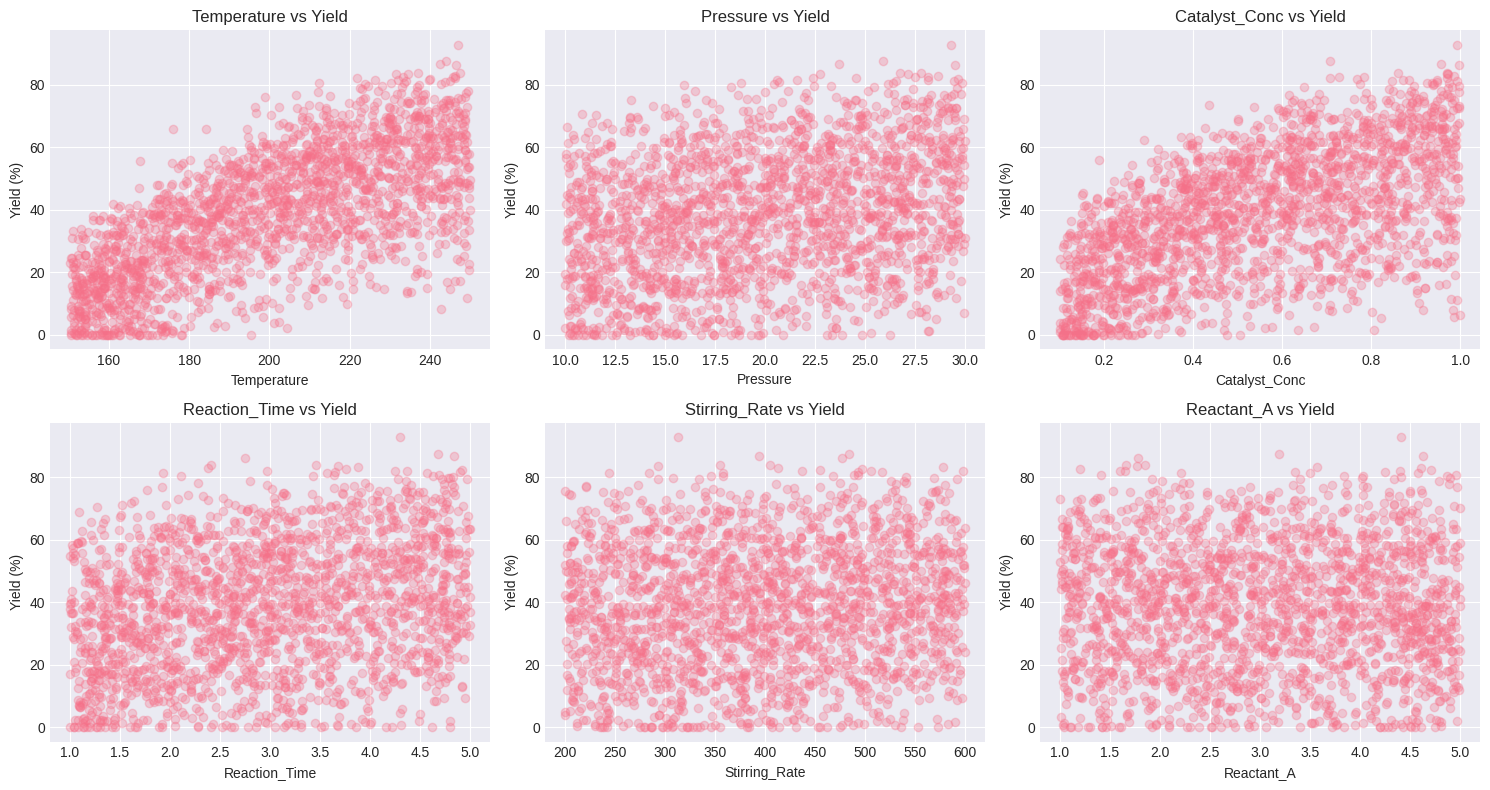

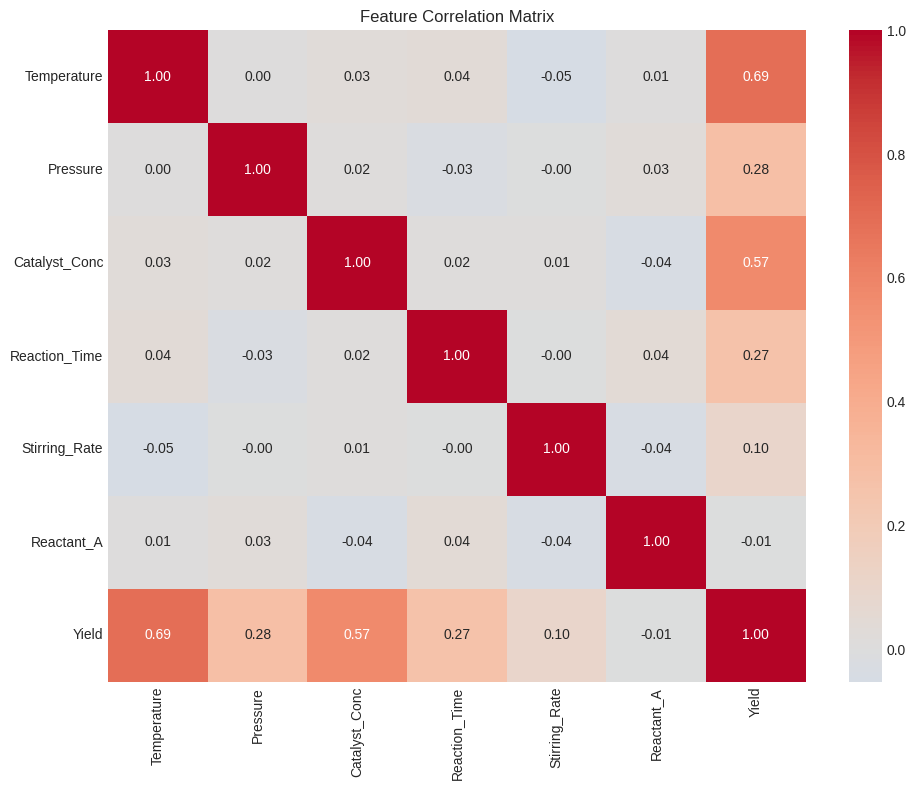

In [33]:
# 產率分佈
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

features = ['Temperature', 'Pressure', 'Catalyst_Conc', 
            'Reaction_Time', 'Stirring_Rate', 'Reactant_A']

for idx, feature in enumerate(features):
    axes[idx].scatter(df_process[feature], df_process['Yield'], alpha=0.3)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Yield (%)')
    axes[idx].set_title(f'{feature} vs Yield')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

# 相關性矩陣
plt.figure(figsize=(10, 8))
correlation_matrix = df_process.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### 1.3 數據預處理

In [34]:
# 分離特徵和目標
X = df_process.drop('Yield', axis=1).values
y = df_process['Yield'].values

print(f"特徵矩陣形狀: {X.shape}")
print(f"目標變數形狀: {y.shape}")

# 切分訓練集、驗證集和測試集
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42  # 0.176 * 0.85 ≈ 0.15
)

print(f"\n訓練集大小: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"驗證集大小: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"測試集大小: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

# 特徵標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n✅ 數據預處理完成")
print(f"標準化後訓練集均值: {X_train_scaled.mean(axis=0).round(2)}")
print(f"標準化後訓練集標準差: {X_train_scaled.std(axis=0).round(2)}")

特徵矩陣形狀: (2000, 6)
目標變數形狀: (2000,)

訓練集大小: 1400 (70.0%)
驗證集大小: 300 (15.0%)
測試集大小: 300 (15.0%)

✅ 數據預處理完成
標準化後訓練集均值: [ 0.  0. -0. -0. -0. -0.]
標準化後訓練集標準差: [1. 1. 1. 1. 1. 1.]


### 1.4 建立 DNN 模型

In [35]:
# 建立 DNN 模型
def create_dnn_model(input_dim, hidden_layers=[64, 32, 16], dropout_rate=0.3):
    """
    建立 DNN 模型
    
    Parameters:
    -----------
    input_dim : int
        輸入特徵數量
    hidden_layers : list
        每層的神經元數量
    dropout_rate : float
        Dropout 比例
    
    Returns:
    --------
    model : Sequential
        編譯好的模型
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    # 輸入層 + 第一隱藏層
    model.add(Dense(hidden_layers[0], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # 其他隱藏層
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # 輸出層（迴歸問題）
    model.add(Dense(1, activation='linear'))
    
    # 編譯模型
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model


# 建立模型
input_dim = X_train_scaled.shape[1]
dnn_model = create_dnn_model(input_dim, hidden_layers=[64, 32, 16], dropout_rate=0.3)

# 顯示模型結構
print("DNN 模型結構:")
dnn_model.summary()

# 計算參數量
total_params = dnn_model.count_params()
print(f"\n總參數量: {total_params:,}")

DNN 模型結構:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 224 (896.00 B)


總參數量: 3,521


### 1.5 訓練模型

In [36]:
# 設定 Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-7,
    verbose=1
)

# 訓練模型
print("開始訓練 DNN 模型...\n")
history_dnn = dnn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✅ 訓練完成")

開始訓練 DNN 模型...

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1919.9924 - mae: 38.8284 - val_loss: 1916.3335 - val_mae: 39.5663 - learning_rate: 0.0010
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1838.9066 - mae: 38.4841 - val_loss: 1863.7987 - val_mae: 39.3503 - learning_rate: 0.0010
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1759.6871 - mae: 38.1273 - val_loss: 1793.3413 - val_mae: 39.0564 - learning_rate: 0.0010
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1685.3925 - mae: 37.6807 - val_loss: 1710.2443 - val_mae: 38.6217 - learning_rate: 0.0010
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1612.8284 - mae: 37.1812 - val_loss: 1599.5887 - val_mae: 37.8176 - learning_rate: 0.0010
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1514.6896 - mae: 36.3781 - val_loss: 1481.6350 - val_mae: 36.8442 - learning_rate: 0.0010
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1444.3550 - mae: 35.8333 - val

### 1.6 訓練歷史視覺化

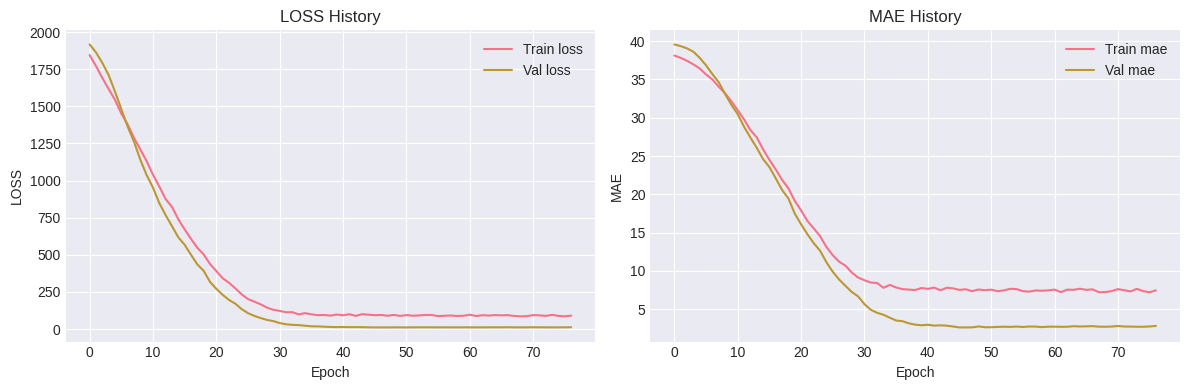

In [37]:
# 繪製訓練歷史
plot_training_history(history_dnn, metrics=['loss', 'mae'])

### 1.7 模型評估

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

DNN 模型 評估結果:
  MSE  = 12.6499
  RMSE = 3.5567
  MAE  = 2.8586
  R²   = 0.9646


/tmp/ipython-input-3487544458.py:77: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3487544458.py:77: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


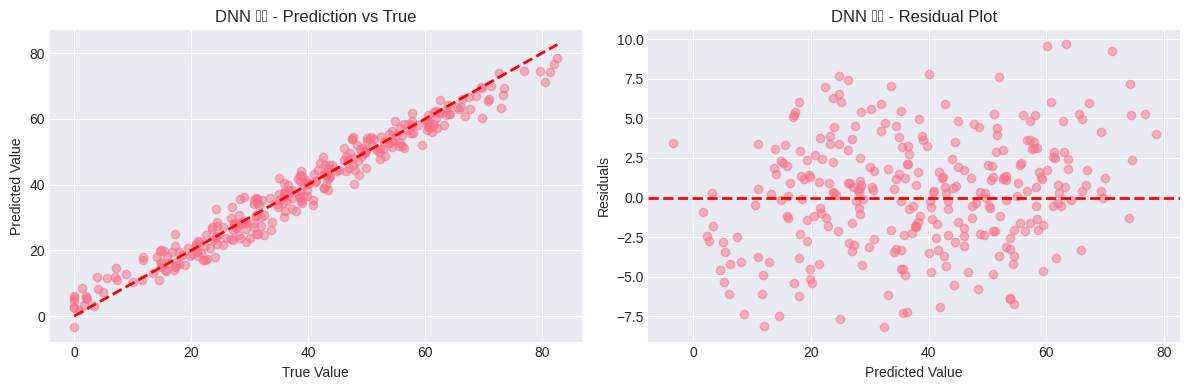

In [38]:
# 在測試集上進行預測
y_pred_dnn = dnn_model.predict(X_test_scaled).flatten()

# 評估模型
results_dnn = evaluate_regression_model(y_test, y_pred_dnn, model_name='DNN 模型')

### 1.8 預測範例

In [39]:
# 選擇幾個測試樣本進行預測
n_samples_to_show = 10
sample_indices = np.random.choice(len(X_test), n_samples_to_show, replace=False)

print("\n預測範例 (前 10 筆測試數據):")
print("="*80)
print(f"{'編號':<6} {'真實產率':<12} {'預測產率':<12} {'誤差':<12} {'誤差%':<12}")
print("="*80)

for i in sample_indices:
    true_val = y_test[i]
    pred_val = y_pred_dnn[i]
    error = true_val - pred_val
    error_pct = abs(error) / true_val * 100
    
    print(f"{i:<6} {true_val:<12.2f} {pred_val:<12.2f} {error:<12.2f} {error_pct:<12.2f}")

print("="*80)


預測範例 (前 10 筆測試數據):
編號     真實產率         預測產率         誤差           誤差%         
275    35.07        35.28        -0.21        0.60        
81     39.73        40.33        -0.61        1.52        
35     50.64        53.88        -3.24        6.41        
46     32.42        30.73        1.69         5.20        
180    22.46        24.59        -2.12        9.45        
130    14.88        16.01        -1.13        7.59        
80     70.99        66.06        4.93         6.94        
53     34.99        37.26        -2.26        6.47        
48     60.87        57.27        3.60         5.92        
268    70.78        65.49        5.30         7.48        


### 1.9 DNN 小結

✅ **完成項目**:
- 使用 DNN/MLP 模型預測化工製程產率
- 了解如何建立、訓練和評估 DNN 模型
- 學習如何使用 EarlyStopping 和 ReduceLROnPlateau
- 掌握迴歸問題的評估指標

📊 **關鍵發現**:
- DNN 能夠學習特徵之間的非線性關係
- Batch Normalization 和 Dropout 有助於模型泛化
- 適當的網路深度和寬度對效能很重要

---

# 範例 2: CNN - 光譜數據分類

## 問題描述
在化工分析中，我們經常使用光譜技術（如 IR、Raman、UV-Vis）來識別化合物或材料。
光譜數據具有局部特徵的特性，相鄰波長之間存在相關性，因此適合使用 1D CNN 進行分類。

## 數據集說明
我們將模擬三種不同化合物的紅外光譜數據：
- **Class 0**: 醇類 (Alcohol)
- **Class 1**: 酮類 (Ketone)  
- **Class 2**: 酯類 (Ester)

每個光譜有 200 個波長點，代表吸收強度。

### 2.1 生成模擬光譜數據

In [40]:
def generate_spectrum(spectrum_type, n_points=200):
    """
    生成模擬光譜數據
    
    Parameters:
    -----------
    spectrum_type : int
        光譜類型 (0: 醇, 1: 酮, 2: 酯)
    n_points : int
        光譜點數
    
    Returns:
    --------
    spectrum : array
        光譜數據
    """
    x = np.linspace(0, 10, n_points)
    
    # 基線
    baseline = np.random.uniform(0.1, 0.3, n_points)
    
    if spectrum_type == 0:  # 醇類 - O-H 拉伸在 3200-3600 cm⁻¹
        peak1 = 2.0 * np.exp(-((x - 3.5) ** 2) / 0.5)
        peak2 = 1.0 * np.exp(-((x - 7.0) ** 2) / 0.3)
        spectrum = baseline + peak1 + peak2
        
    elif spectrum_type == 1:  # 酮類 - C=O 拉伸在 1700 cm⁻¹
        peak1 = 2.5 * np.exp(-((x - 5.0) ** 2) / 0.3)
        peak2 = 0.8 * np.exp(-((x - 2.5) ** 2) / 0.4)
        spectrum = baseline + peak1 + peak2
        
    else:  # 酯類 - C=O 和 C-O 拉伸
        peak1 = 2.0 * np.exp(-((x - 4.8) ** 2) / 0.3)
        peak2 = 1.5 * np.exp(-((x - 6.5) ** 2) / 0.4)
        peak3 = 0.8 * np.exp(-((x - 2.0) ** 2) / 0.3)
        spectrum = baseline + peak1 + peak2 + peak3
    
    # 添加噪音
    noise = np.random.normal(0, 0.1, n_points)
    spectrum += noise
    
    return spectrum


# 生成數據集
np.random.seed(42)
n_samples_per_class = 400
n_points = 200
n_classes = 3

X_spectra = []
y_spectra = []

#class_names = ['醇類', '酮類', '酯類']
class_names = ['Alcohol', 'Ketone', 'Ester']

for class_id in range(n_classes):
    for _ in range(n_samples_per_class):
        spectrum = generate_spectrum(class_id, n_points)
        X_spectra.append(spectrum)
        y_spectra.append(class_id)

X_spectra = np.array(X_spectra)
y_spectra = np.array(y_spectra)

print(f"光譜數據形狀: {X_spectra.shape}")
print(f"標籤形狀: {y_spectra.shape}")
print(f"\n類別分佈:")
for i, name in enumerate(class_names):
    count = np.sum(y_spectra == i)
    print(f"  {name}: {count} 個樣本")

光譜數據形狀: (1200, 200)
標籤形狀: (1200,)

類別分佈:
  Alcohol: 400 個樣本
  Ketone: 400 個樣本
  Ester: 400 個樣本


### 2.2 光譜數據視覺化

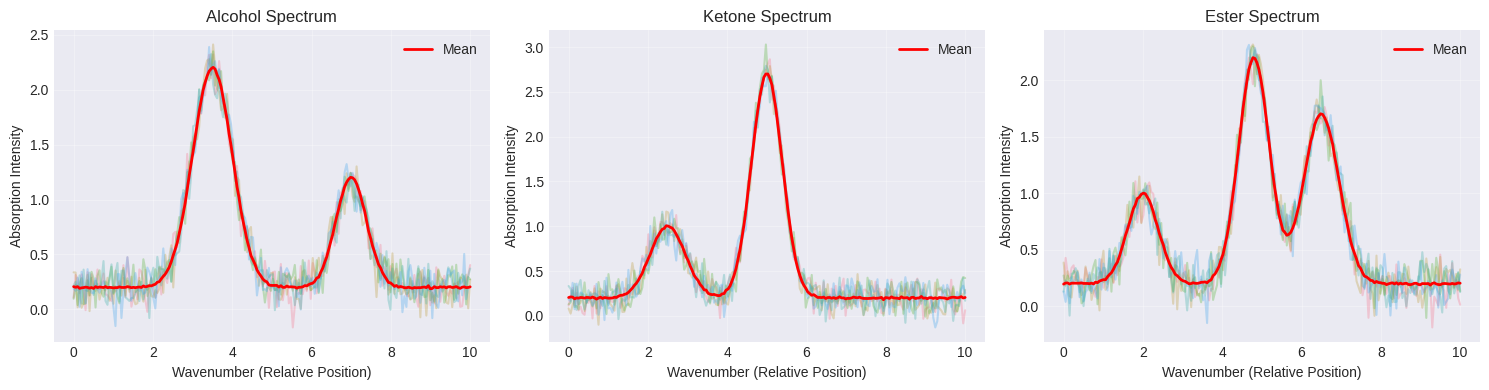

In [41]:
# 繪製每類的代表性光譜
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

x_axis = np.linspace(0, 10, n_points)

for class_id in range(n_classes):
    # 選擇該類別的樣本
    class_samples = X_spectra[y_spectra == class_id]
    
    # 繪製多個樣本
    for i in range(min(5, len(class_samples))):
        axes[class_id].plot(x_axis, class_samples[i], alpha=0.3)
    
    # 繪製平均光譜
    mean_spectrum = class_samples.mean(axis=0)
    axes[class_id].plot(x_axis, mean_spectrum, 'r-', linewidth=2, label='Mean')
    
    axes[class_id].set_xlabel('Wavenumber (Relative Position)')
    axes[class_id].set_ylabel('Absorption Intensity')
    axes[class_id].set_title(f'{class_names[class_id]} Spectrum')
    axes[class_id].legend()
    axes[class_id].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.3 數據預處理

In [42]:
# 打亂數據
shuffle_indices = np.random.permutation(len(X_spectra))
X_spectra = X_spectra[shuffle_indices]
y_spectra = y_spectra[shuffle_indices]

# 切分數據集
X_temp, X_test_spec, y_temp, y_test_spec = train_test_split(
    X_spectra, y_spectra, test_size=0.15, random_state=42, stratify=y_spectra
)
X_train_spec, X_val_spec, y_train_spec, y_val_spec = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"訓練集大小: {X_train_spec.shape[0]}")
print(f"驗證集大小: {X_val_spec.shape[0]}")
print(f"測試集大小: {X_test_spec.shape[0]}")

# 標準化光譜數據
spec_scaler = StandardScaler()
X_train_spec_scaled = spec_scaler.fit_transform(X_train_spec)
X_val_spec_scaled = spec_scaler.transform(X_val_spec)
X_test_spec_scaled = spec_scaler.transform(X_test_spec)

# CNN 需要 3D 輸入: (samples, timesteps, features)
X_train_spec_cnn = X_train_spec_scaled.reshape(-1, n_points, 1)
X_val_spec_cnn = X_val_spec_scaled.reshape(-1, n_points, 1)
X_test_spec_cnn = X_test_spec_scaled.reshape(-1, n_points, 1)

print(f"\nCNN 輸入形狀: {X_train_spec_cnn.shape}")

# One-hot 編碼標籤
y_train_spec_cat = to_categorical(y_train_spec, num_classes=n_classes)
y_val_spec_cat = to_categorical(y_val_spec, num_classes=n_classes)
y_test_spec_cat = to_categorical(y_test_spec, num_classes=n_classes)

print(f"One-hot 標籤形狀: {y_train_spec_cat.shape}")
print("\n✅ 數據預處理完成")

訓練集大小: 840
驗證集大小: 180
測試集大小: 180

CNN 輸入形狀: (840, 200, 1)
One-hot 標籤形狀: (840, 3)

✅ 數據預處理完成


### 2.4 建立 1D CNN 模型

In [43]:
def create_1d_cnn_model(input_shape, num_classes):
    """
    建立 1D CNN 模型
    
    Parameters:
    -----------
    input_shape : tuple
        輸入形狀 (timesteps, features)
    num_classes : int
        類別數量
    
    Returns:
    --------
    model : Sequential
        編譯好的模型
    """
    model = Sequential([
        # 第一組卷積層
        Input(shape=input_shape),
        Conv1D(32, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # 第二組卷積層
        Conv1D(64, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # 第三組卷積層
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        
        # 全局平均池化
        GlobalAveragePooling1D(),
        
        # 全連接層
        Dense(64, activation='relu'),
        Dropout(0.4),
        
        # 輸出層
        Dense(num_classes, activation='softmax')
    ])
    
    # 編譯模型
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# 建立模型
input_shape = (n_points, 1)
cnn_model = create_1d_cnn_model(input_shape, num_classes=n_classes)

# 顯示模型結構
print("1D CNN 模型結構:")
cnn_model.summary()

# 計算參數量
total_params = cnn_model.count_params()
print(f"\n總參數量: {total_params:,}")

1D CNN 模型結構:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 196, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 196, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 98, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 98, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 94, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 94, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 45, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 45, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,547 (174.01 KB)

 Trainable params: 44,099 (172.26 KB)

 Non-trainable params: 448 (1.75 KB)


總參數量: 44,547


### 2.5 訓練模型

In [44]:
# 設定 Callbacks
early_stop_cnn = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cnn = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# 訓練模型
print("開始訓練 1D CNN 模型...\n")
history_cnn = cnn_model.fit(
    X_train_spec_cnn, y_train_spec_cat,
    validation_data=(X_val_spec_cnn, y_val_spec_cat),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop_cnn, reduce_lr_cnn],
    verbose=1
)

print("\n✅ 訓練完成")

開始訓練 1D CNN 模型...

Epoch 1/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7208 - loss: 0.7332 - val_accuracy: 0.6444 - val_loss: 0.8078 - learning_rate: 0.0010
Epoch 2/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9945 - loss: 0.1032 - val_accuracy: 0.4611 - val_loss: 1.1361 - learning_rate: 0.0010
Epoch 3/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 0.0275 - val_accuracy: 0.6611 - val_loss: 1.6641 - learning_rate: 0.0010
Epoch 4/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 0.6667 - val_loss: 2.2258 - learning_rate: 0.0010
Epoch 5/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9996 - loss: 0.0081 - val_accuracy: 0.6667 - val_loss: 2.6868 - learning_rate: 0.0010
Epoch 6/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.6667 - val_loss: 3.0549 - learning_rate: 0.0010
Epoch 7/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 1.000

### 2.6 訓練歷史視覺化

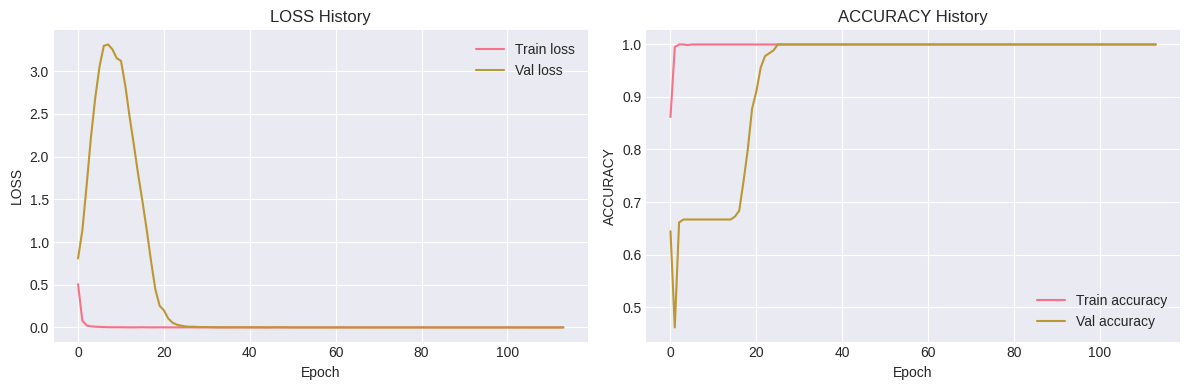

In [45]:
# 繪製訓練歷史
plot_training_history(history_cnn, metrics=['loss', 'accuracy'])

### 2.7 模型評估


測試集評估結果:
  損失 (Loss): 0.0002
  準確率 (Accuracy): 1.0000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

分類報告:
              precision    recall  f1-score   support

     Alcohol     1.0000    1.0000    1.0000        60
      Ketone     1.0000    1.0000    1.0000        60
       Ester     1.0000    1.0000    1.0000        60

    accuracy                         1.0000       180
   macro avg     1.0000    1.0000    1.0000       180
weighted avg     1.0000    1.0000    1.0000       180



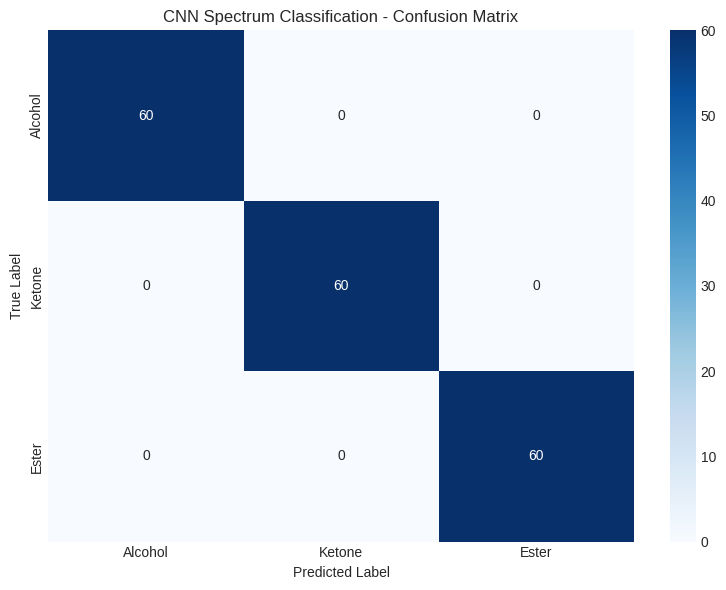

In [46]:
# 在測試集上評估
test_loss, test_accuracy = cnn_model.evaluate(X_test_spec_cnn, y_test_spec_cat, verbose=0)

print(f"\n測試集評估結果:")
print(f"  損失 (Loss): {test_loss:.4f}")
print(f"  準確率 (Accuracy): {test_accuracy:.4f}")

# 預測
y_pred_spec_proba = cnn_model.predict(X_test_spec_cnn)
y_pred_spec = np.argmax(y_pred_spec_proba, axis=1)

# 分類報告
print(f"\n分類報告:")
print(classification_report(y_test_spec, y_pred_spec, 
                          target_names=class_names, digits=4))

# 混淆矩陣
plot_confusion_matrix(y_test_spec, y_pred_spec, class_names, 
                     title='CNN Spectrum Classification - Confusion Matrix')

### 2.8 預測範例視覺化

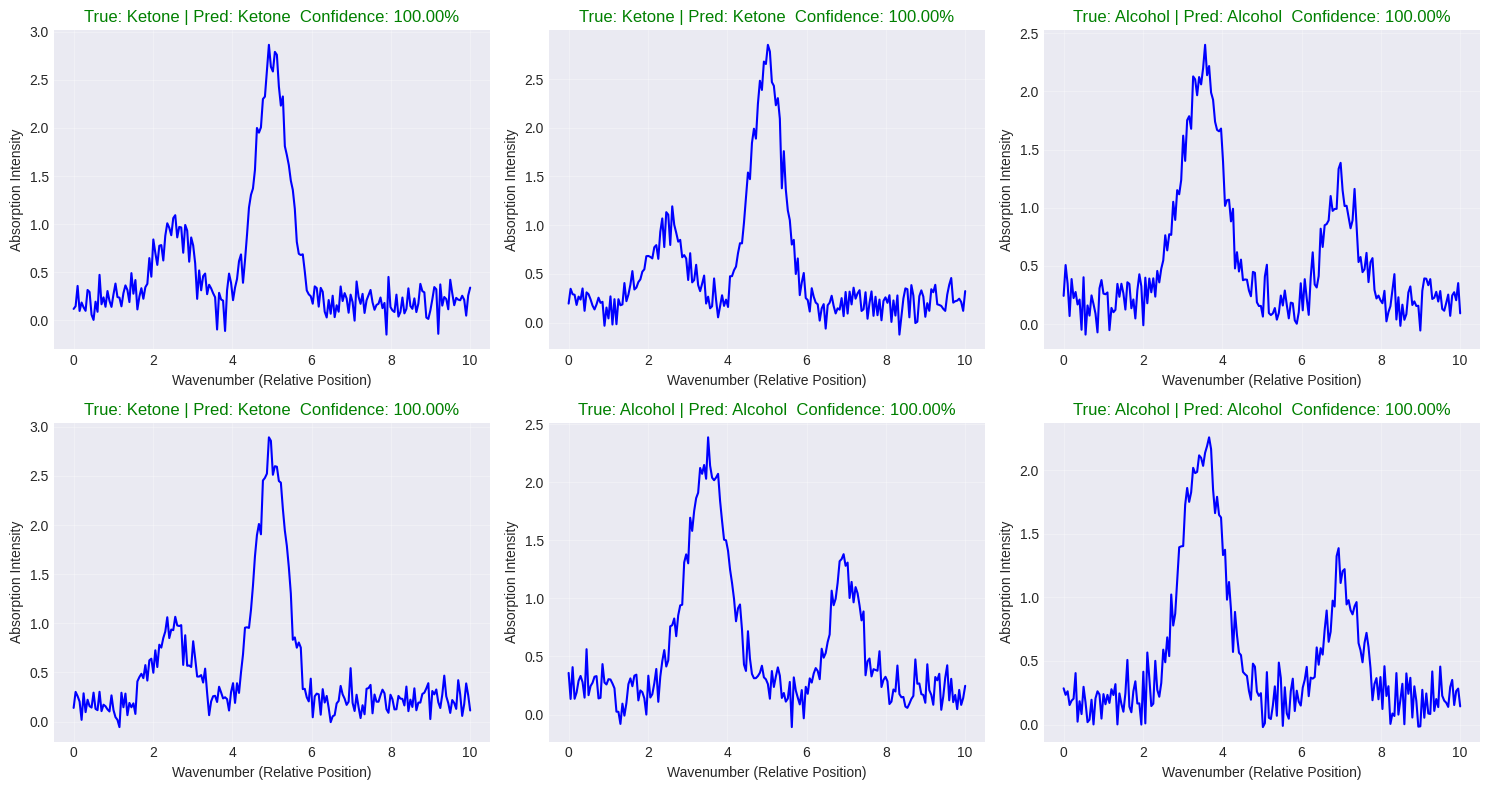


預測機率範例 (前 10 筆):
編號     真實       預測       醇類           酮類           酯類          
0      Ester    Ester    0.0000       0.0000       1.0000      
1      Ester    Ester    0.0000       0.0000       1.0000      
2      Ester    Ester    0.0000       0.0000       1.0000      
3      Ketone   Ketone   0.0000       1.0000       0.0000      
4      Ketone   Ketone   0.0000       1.0000       0.0000      
5      Ester    Ester    0.0000       0.0000       1.0000      
6      Ketone   Ketone   0.0000       1.0000       0.0000      
7      Ester    Ester    0.0000       0.0000       1.0000      
8      Ester    Ester    0.0000       0.0000       1.0000      
9      Ester    Ester    0.0000       0.0000       1.0000      


In [47]:
# 選擇一些測試樣本視覺化預測結果
n_samples_show = 6
sample_indices = np.random.choice(len(X_test_spec), n_samples_show, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

x_axis = np.linspace(0, 10, n_points)

for idx, sample_idx in enumerate(sample_indices):
    spectrum = X_test_spec[sample_idx]
    true_label = y_test_spec[sample_idx]
    pred_label = y_pred_spec[sample_idx]
    pred_proba = y_pred_spec_proba[sample_idx]
    
    axes[idx].plot(x_axis, spectrum, 'b-', linewidth=1.5)
    axes[idx].set_xlabel('Wavenumber (Relative Position)')
    axes[idx].set_ylabel('Absorption Intensity')
    
    # 標題顯示真實和預測結果
    title_color = 'green' if true_label == pred_label else 'red'
    axes[idx].set_title(
        f'True: {class_names[true_label]} | Pred: {class_names[pred_label]}  Confidence: {pred_proba[pred_label]:.2%}',
        color=title_color
    )
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 顯示預測機率
print("\n預測機率範例 (前 10 筆):")
print("="*70)
print(f"{'編號':<6} {'真實':<8} {'預測':<8} {'醇類':<12} {'酮類':<12} {'酯類':<12}")
print("="*70)

for i in range(min(10, len(y_test_spec))):
    true_class = class_names[y_test_spec[i]]
    pred_class = class_names[y_pred_spec[i]]
    probs = y_pred_spec_proba[i]
    
    print(f"{i:<6} {true_class:<8} {pred_class:<8} "
          f"{probs[0]:<12.4f} {probs[1]:<12.4f} {probs[2]:<12.4f}")

print("="*70)

### 2.9 CNN 小結

✅ **完成項目**:
- 使用 1D CNN 模型進行光譜數據分類
- 了解如何處理序列型數據用於 CNN
- 學習卷積層和池化層的應用
- 掌握多分類問題的評估方法

📊 **關鍵發現**:
- CNN 能夠自動提取光譜的局部特徵
- 卷積操作對鄰近波長的相關性敏感
- GlobalAveragePooling 可以有效減少參數量
- 適合處理具有局部結構的數據

---

# 範例 3: LSTM - 製程時間序列預測

## 問題描述
在化工製程中，反應器溫度是一個重要的監控變數。我們希望根據過去的溫度歷史數據，預測未來的溫度變化。
這是一個典型的時間序列預測問題，適合使用 LSTM 模型。

## 數據集說明
模擬一個批次反應器的溫度時間序列：
- **特徵**: 
  - 溫度 (Temperature, °C)
  - 壓力 (Pressure, bar)
  - 流量 (Flow Rate, L/min)
- **目標**: 下一時刻的溫度

數據包含週期性變化、趨勢和噪音，模擬真實的製程情況。

### 3.1 生成模擬時間序列數據

In [48]:
# 生成模擬反應器時間序列數據
np.random.seed(42)

# 時間序列長度
n_timesteps = 5000
time = np.arange(n_timesteps)

# 生成溫度數據（目標變數）
# 包含趨勢、週期性和噪音
trend = 150 + 0.005 * time  # 緩慢上升趨勢
seasonality = 10 * np.sin(2 * np.pi * time / 200)  # 週期性變化
noise = np.random.normal(0, 2, n_timesteps)  # 隨機噪音
temperature = trend + seasonality + noise

# 生成壓力數據（相關特徵）
pressure = 20 + 0.003 * time + 3 * np.sin(2 * np.pi * time / 200 + 0.5) + np.random.normal(0, 1, n_timesteps)

# 生成流量數據（相關特徵）
flow_rate = 50 + 2 * np.sin(2 * np.pi * time / 150) + np.random.normal(0, 1.5, n_timesteps)

# 建立 DataFrame
df_timeseries = pd.DataFrame({
    'Time': time,
    'Temperature': temperature,
    'Pressure': pressure,
    'Flow_Rate': flow_rate
})

print(f"時間序列數據大小: {df_timeseries.shape}")
print(f"\n前 5 筆數據:")
print(df_timeseries.head())
print(f"\n統計資訊:")
print(df_timeseries.describe())

時間序列數據大小: (5000, 4)

前 5 筆數據:
   Time  Temperature   Pressure  Flow_Rate
0     0   150.993428  21.014517  48.982258
1     1   150.042579  21.069849  49.625502
2     2   151.933282  19.811107  49.271284
3     3   154.002143  21.358567  50.416294
4     4   150.805026  22.501735  52.129305

統計資訊:
              Time  Temperature     Pressure    Flow_Rate
count  5000.000000  5000.000000  5000.000000  5000.000000
mean   2499.500000   162.508704    27.488626    50.029978
std    1443.520003    10.106333     4.878207     2.077265
min       0.000000   137.809202    15.819787    43.450342
25%    1249.750000   155.231944    23.730179    48.556095
50%    2499.500000   162.553040    27.525339    50.041669
75%    3749.250000   169.878839    31.299008    51.499046
max    4999.000000   189.348085    39.667511    56.803150


### 3.2 時間序列數據視覺化

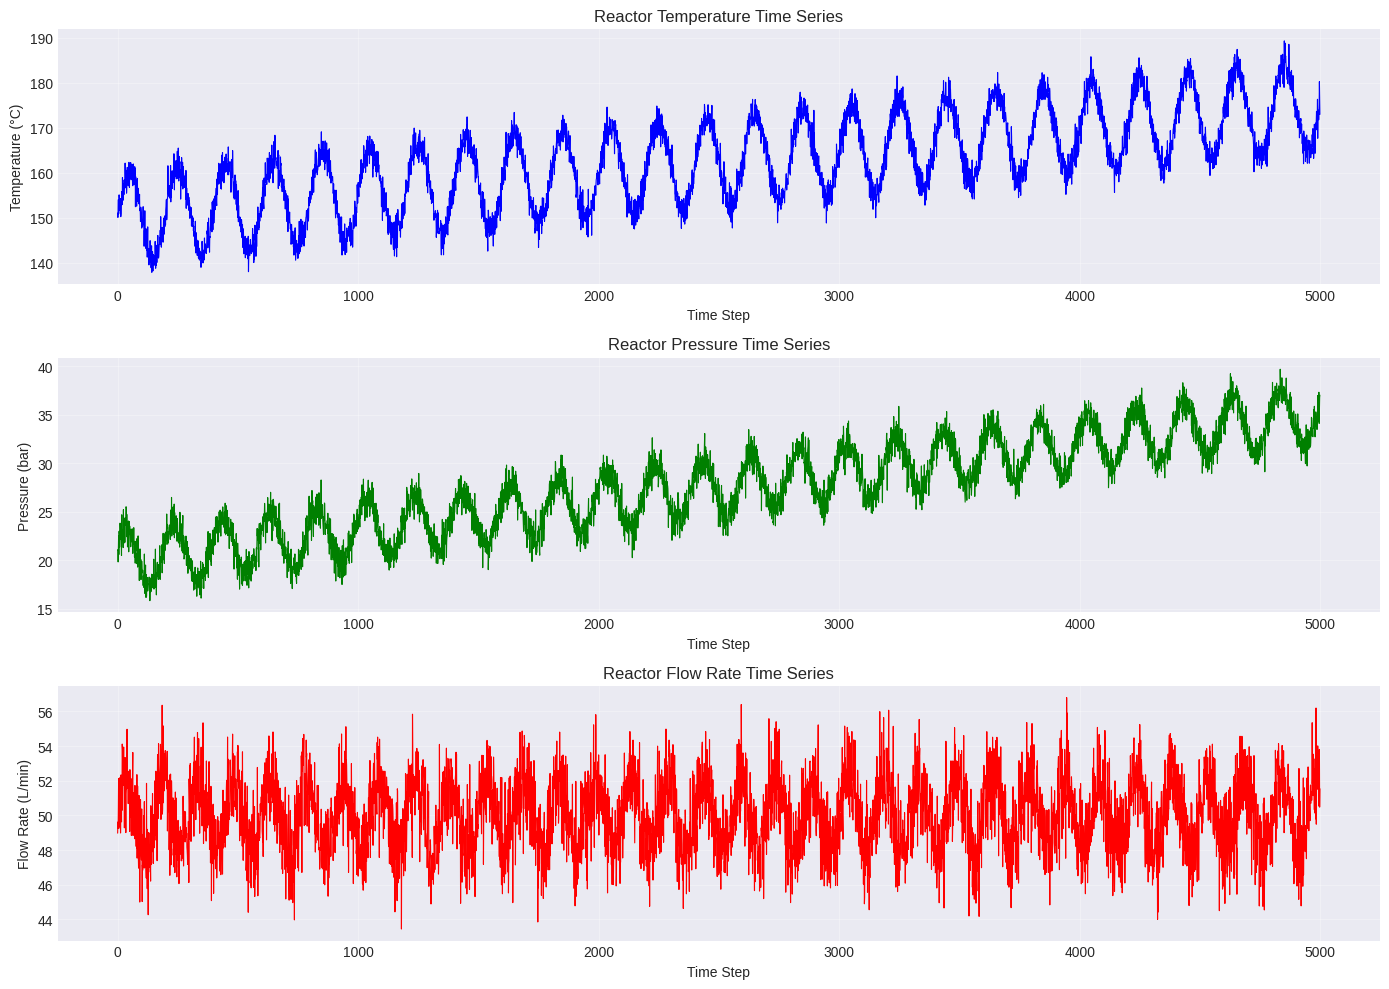

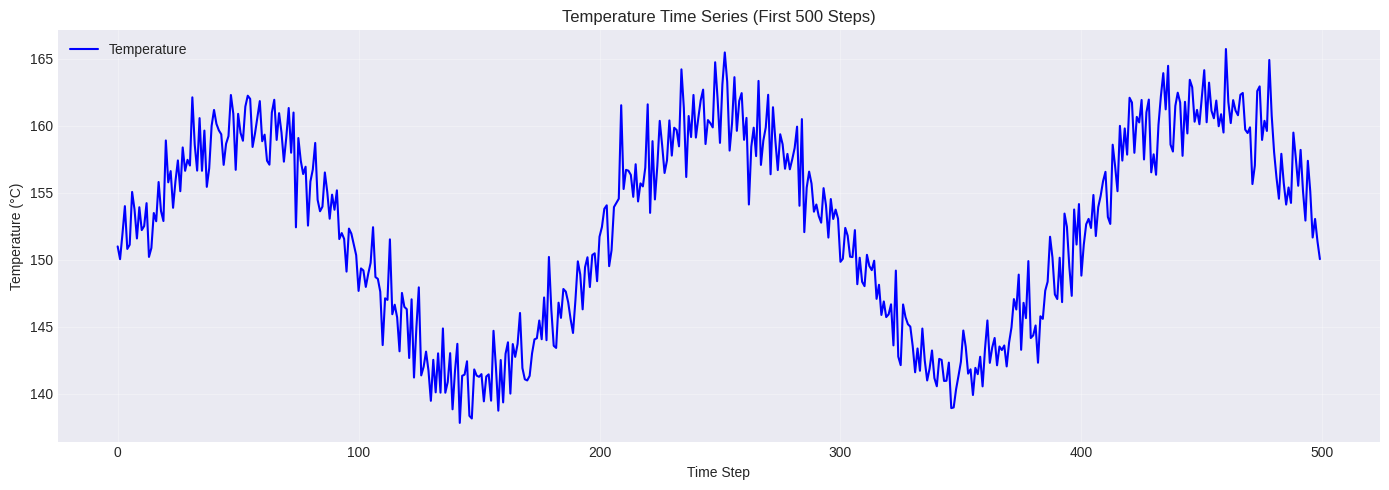

In [49]:
# 繪製時間序列數據
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 溫度
axes[0].plot(df_timeseries['Time'], df_timeseries['Temperature'], 'b-', linewidth=0.8)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Reactor Temperature Time Series')
axes[0].grid(True, alpha=0.3)

# 壓力
axes[1].plot(df_timeseries['Time'], df_timeseries['Pressure'], 'g-', linewidth=0.8)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Pressure (bar)')
axes[1].set_title('Reactor Pressure Time Series')
axes[1].grid(True, alpha=0.3)

# 流量
axes[2].plot(df_timeseries['Time'], df_timeseries['Flow_Rate'], 'r-', linewidth=0.8)
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Flow Rate (L/min)')
axes[2].set_title('Reactor Flow Rate Time Series')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 顯示局部放大
fig, ax = plt.subplots(figsize=(14, 5))
start_idx, end_idx = 0, 500
ax.plot(df_timeseries['Time'][start_idx:end_idx], 
        df_timeseries['Temperature'][start_idx:end_idx], 
        'b-', linewidth=1.5, label='Temperature')
ax.set_xlabel('Time Step')
ax.set_ylabel('Temperature (°C)')
ax.set_title(f'Temperature Time Series (First {end_idx} Steps)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 建立序列數據與預處理

In [50]:
# 準備特徵和目標
data = df_timeseries[['Temperature', 'Pressure', 'Flow_Rate']].values

# 數據標準化
ts_scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = ts_scaler.fit_transform(data)

print(f"標準化後數據形狀: {data_scaled.shape}")
print(f"標準化後數據範圍: [{data_scaled.min():.2f}, {data_scaled.max():.2f}]")

# 建立滑動窗口序列數據
def create_sequences(data, window_size, target_col=0):
    """
    建立時間序列的滑動窗口數據
    
    Parameters:
    -----------
    data : array
        時間序列數據
    window_size : int
        窗口大小（過去多少個時間步）
    target_col : int
        目標變數的列索引
    
    Returns:
    --------
    X, y : arrays
        輸入序列和目標值
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])  # 過去 window_size 個時間步的所有特徵
        y.append(data[i+window_size, target_col])  # 下一時刻的溫度
    return np.array(X), np.array(y)

# 設定窗口大小
window_size = 50  # 使用過去 50 個時間步預測下一時刻

X_seq, y_seq = create_sequences(data_scaled, window_size, target_col=0)

print(f"\n序列數據形狀:")
print(f"  X: {X_seq.shape}  # (樣本數, 時間步, 特徵數)")
print(f"  y: {y_seq.shape}  # (樣本數,)")

# 切分訓練集、驗證集和測試集
# 時間序列數據應該按時間順序切分（不打亂）
train_size = int(0.7 * len(X_seq))
val_size = int(0.15 * len(X_seq))

X_train_seq = X_seq[:train_size]
y_train_seq = y_seq[:train_size]

X_val_seq = X_seq[train_size:train_size+val_size]
y_val_seq = y_seq[train_size:train_size+val_size]

X_test_seq = X_seq[train_size+val_size:]
y_test_seq = y_seq[train_size+val_size:]

print(f"\n數據集切分:")
print(f"  訓練集: {X_train_seq.shape[0]} 樣本 ({X_train_seq.shape[0]/len(X_seq)*100:.1f}%)")
print(f"  驗證集: {X_val_seq.shape[0]} 樣本 ({X_val_seq.shape[0]/len(X_seq)*100:.1f}%)")
print(f"  測試集: {X_test_seq.shape[0]} 樣本 ({X_test_seq.shape[0]/len(X_seq)*100:.1f}%)")

print("\n✅ 序列數據準備完成")

標準化後數據形狀: (5000, 3)
標準化後數據範圍: [0.00, 1.00]

序列數據形狀:
  X: (4950, 50, 3)  # (樣本數, 時間步, 特徵數)
  y: (4950,)  # (樣本數,)

數據集切分:
  訓練集: 3465 樣本 (70.0%)
  驗證集: 742 樣本 (15.0%)
  測試集: 743 樣本 (15.0%)

✅ 序列數據準備完成


### 3.4 建立 LSTM 模型

In [51]:
def create_lstm_model(input_shape, model_type='lstm'):
    """
    建立 LSTM/GRU 模型
    
    Parameters:
    -----------
    input_shape : tuple
        輸入形狀 (timesteps, features)
    model_type : str
        模型類型: 'lstm' 或 'gru'
    
    Returns:
    --------
    model : Sequential
        編譯好的模型
    """
    model = Sequential()
    
    if model_type.lower() == 'lstm':
        # 多層 LSTM
        model.add(Input(shape=input_shape))
        model.add(LSTM(64, activation='tanh', return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, activation='tanh'))
        model.add(Dropout(0.2))
    elif model_type.lower() == 'gru':
        # 多層 GRU
        model.add(Input(shape=input_shape))
        model.add(GRU(64, activation='tanh', return_sequences=True))
        model.add(Dropout(0.2))
        model.add(GRU(32, activation='tanh'))
        model.add(Dropout(0.2))
    else:
        raise ValueError(f"不支援的模型類型: {model_type}")
    
    # 全連接層
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    
    # 輸出層
    model.add(Dense(1, activation='linear'))
    
    # 編譯模型
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

# 建立 LSTM 模型
input_shape = (window_size, X_train_seq.shape[2])
lstm_model = create_lstm_model(input_shape, model_type='lstm')

# 顯示模型結構
print("LSTM 模型結構:")
lstm_model.summary()

# 計算參數量
total_params = lstm_model.count_params()
print(f"\n總參數量: {total_params:,}")

LSTM 模型結構:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)


總參數量: 30,369


### 3.5 訓練 LSTM 模型

In [52]:
# 設定 Callbacks
early_stop_lstm = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_lstm = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# 訓練模型
print("開始訓練 LSTM 模型...\n")
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_lstm, reduce_lr_lstm],
    verbose=1
)

print("\n✅ 訓練完成")

開始訓練 LSTM 模型...

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0666 - mae: 0.1995 - val_loss: 0.0031 - val_mae: 0.0450 - learning_rate: 0.0010
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0139 - mae: 0.0898 - val_loss: 0.0032 - val_mae: 0.0461 - learning_rate: 0.0010
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0114 - mae: 0.0818 - val_loss: 0.0029 - val_mae: 0.0435 - learning_rate: 0.0010
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0095 - mae: 0.0742 - val_loss: 0.0039 - val_mae: 0.0509 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0088 - mae: 0.0711 - val_loss: 0.0021 - val_mae: 0.0363 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0085 - mae: 0.0713 - val_loss: 0.0019 - val_mae: 0.0350 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0078 - mae: 0.0667 - val_loss: 0.0033 - val_mae: 0.0468 - learning_ra

### 3.6 訓練歷史視覺化

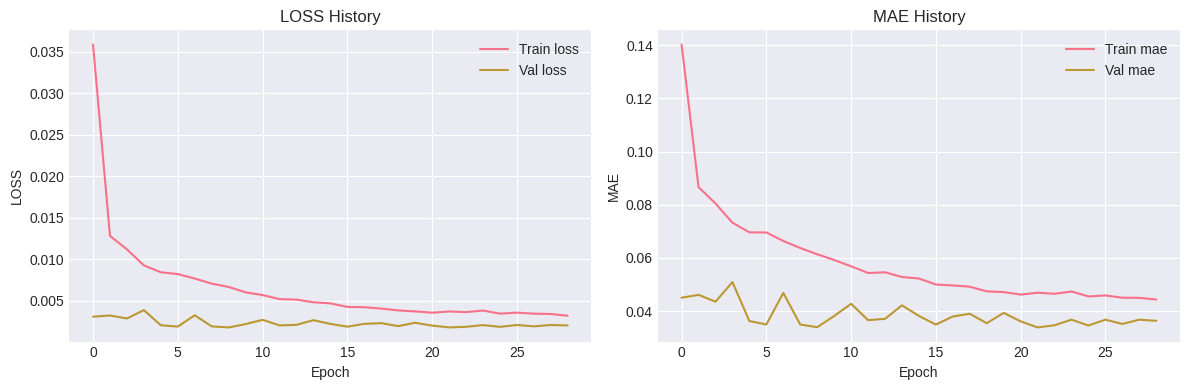

In [53]:
# 繪製訓練歷史
plot_training_history(history_lstm, metrics=['loss', 'mae'])

### 3.7 模型評估與預測

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

LSTM Model 評估結果:
  MSE  = 4.6221
  RMSE = 2.1499
  MAE  = 1.7298
  R²   = 0.9118


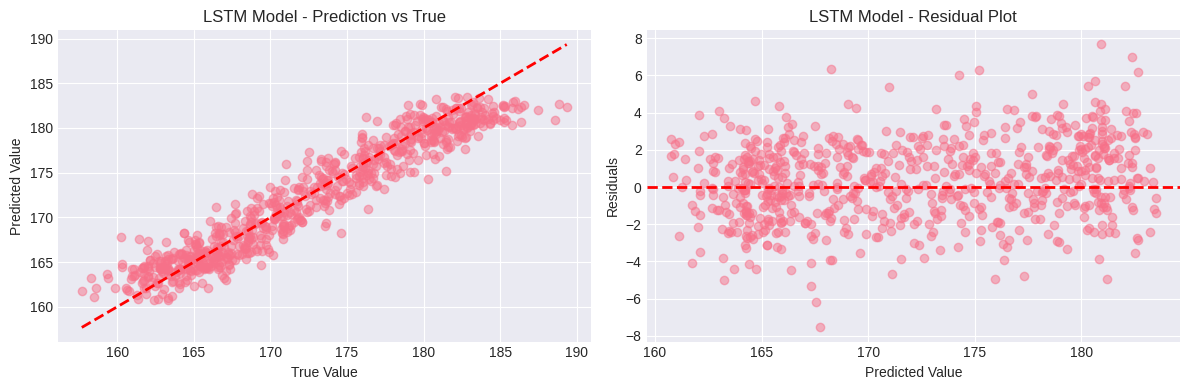

In [54]:
# 在測試集上進行預測
y_pred_lstm_scaled = lstm_model.predict(X_test_seq).flatten()

# 反標準化預測值和真實值
# 創建完整形狀的數組以進行反標準化
y_test_full = np.zeros((len(y_test_seq), 3))
y_test_full[:, 0] = y_test_seq
y_test_inverse = ts_scaler.inverse_transform(y_test_full)[:, 0]

y_pred_full = np.zeros((len(y_pred_lstm_scaled), 3))
y_pred_full[:, 0] = y_pred_lstm_scaled
y_pred_lstm = ts_scaler.inverse_transform(y_pred_full)[:, 0]

# 評估模型
results_lstm = evaluate_regression_model(y_test_inverse, y_pred_lstm, model_name='LSTM Model')

### 3.8 時間序列預測視覺化

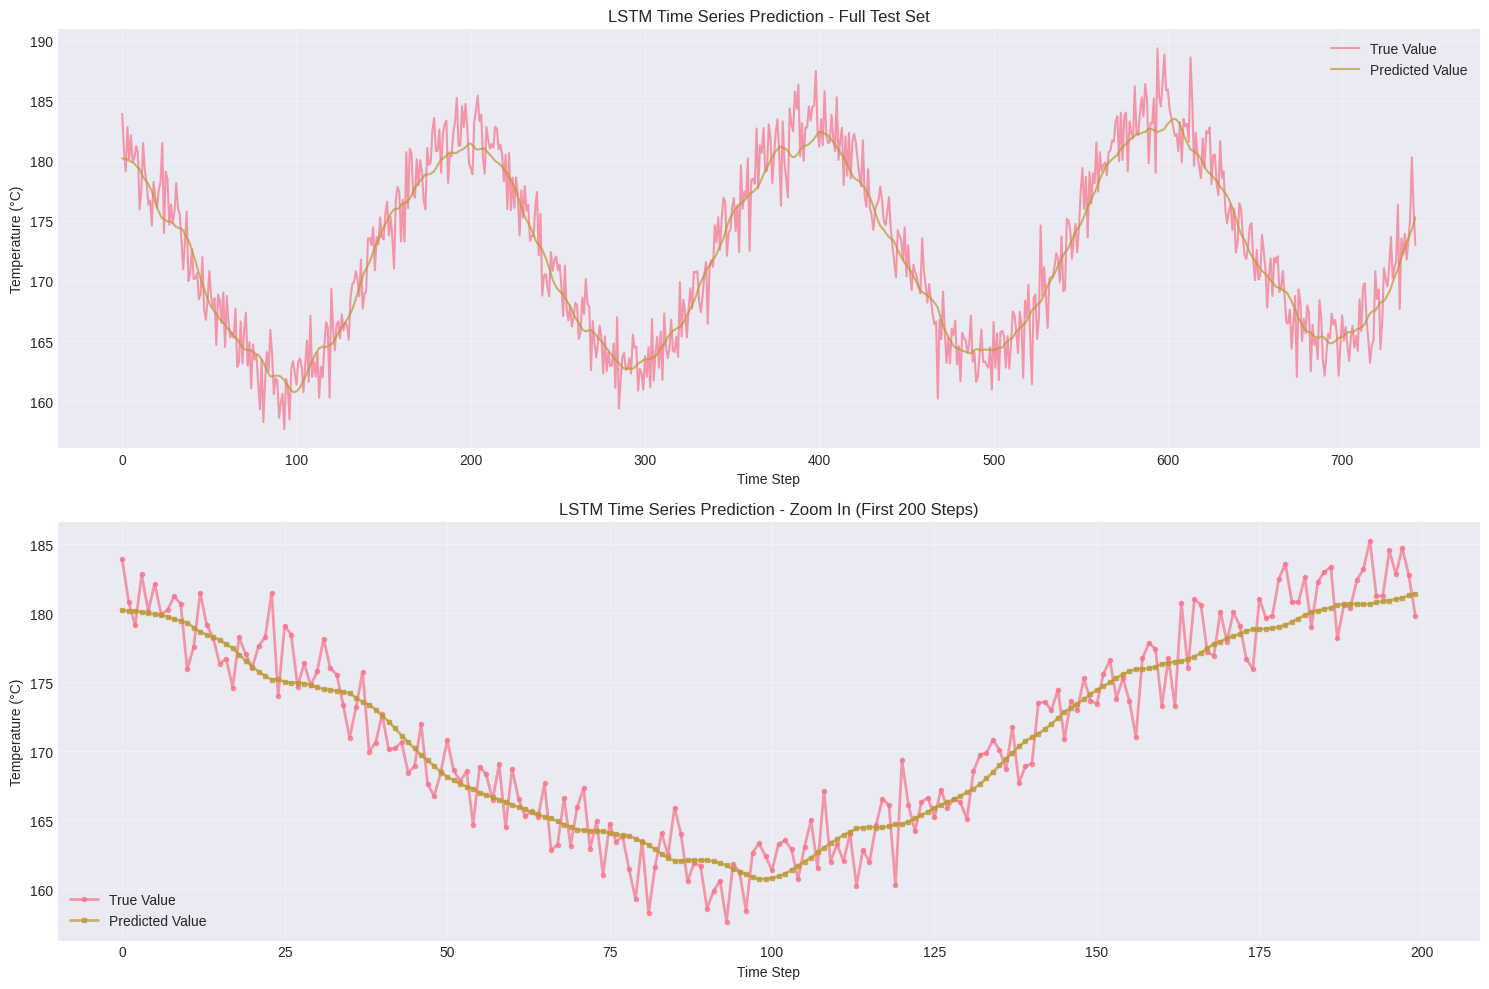


預測範例 (前 20 筆測試數據):
時間步      真實溫度            預測溫度            誤差              誤差%            
0        183.89          180.20          3.70            2.0103         
1        180.79          180.16          0.63            0.3504         
2        179.12          180.16          -1.04           0.5815         
3        182.81          180.08          2.73            1.4936         
4        180.14          180.00          0.14            0.0797         
5        182.13          179.93          2.20            1.2080         
6        179.91          179.88          0.03            0.0183         
7        180.25          179.74          0.51            0.2804         
8        181.22          179.57          1.66            0.9134         
9        180.67          179.45          1.23            0.6789         
10       175.95          179.30          -3.35           1.9043         
11       177.54          178.96          -1.42           0.7976         
12       181.47          178.65

In [55]:
# 繪製完整的預測結果
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 全域視圖
axes[0].plot(y_test_inverse, label='True Value', linewidth=1.5, alpha=0.7)
axes[0].plot(y_pred_lstm, label='Predicted Value', linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('LSTM Time Series Prediction - Full Test Set')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 局部放大視圖
start_idx, end_idx = 0, 200
axes[1].plot(y_test_inverse[start_idx:end_idx], label='True Value', 
             linewidth=2, alpha=0.7, marker='o', markersize=3)
axes[1].plot(y_pred_lstm[start_idx:end_idx], label='Predicted Value', 
             linewidth=2, alpha=0.7, marker='s', markersize=3)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Temperature (°C)')
axes[1].set_title(f'LSTM Time Series Prediction - Zoom In (First {end_idx} Steps)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 顯示預測範例
print("\n預測範例 (前 20 筆測試數據):")
print("="*80)
print(f"{'時間步':<8} {'真實溫度':<15} {'預測溫度':<15} {'誤差':<15} {'誤差%':<15}")
print("="*80)

for i in range(min(20, len(y_test_inverse))):
    true_val = y_test_inverse[i]
    pred_val = y_pred_lstm[i]
    error = true_val - pred_val
    error_pct = abs(error) / true_val * 100
    
    print(f"{i:<8} {true_val:<15.2f} {pred_val:<15.2f} {error:<15.2f} {error_pct:<15.4f}")

print("="*80)

### 3.9 比較 LSTM 與 GRU

建立 GRU 模型...

GRU 模型結構:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 50, 64)         │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,201 (90.63 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 0 (0.00 B)


開始訓練 GRU 模型...


Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 20.
✅ GRU 訓練完成
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

GRU Model 評估結果:
  MSE  = 5.0419
  RMSE = 2.2454
  MAE  = 1.8118
  R²   = 0.9038


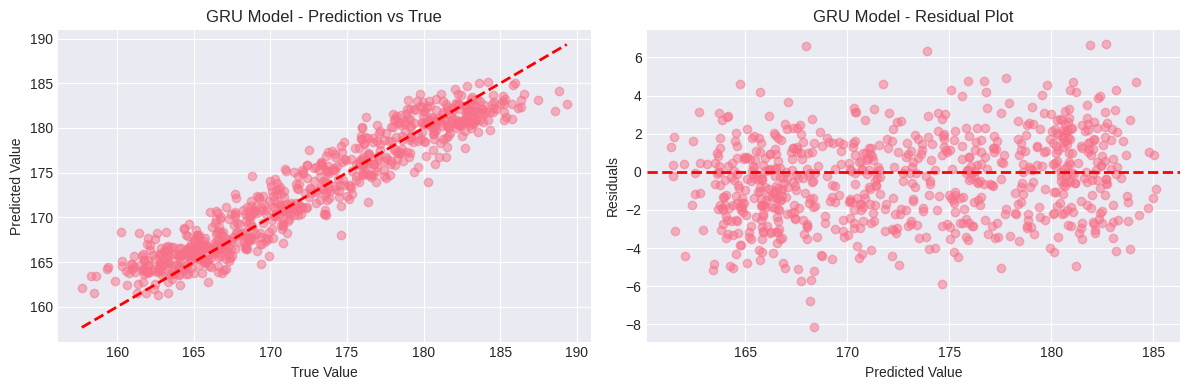

In [56]:
# 建立並訓練 GRU 模型進行比較
print("建立 GRU 模型...")
gru_model = create_lstm_model(input_shape, model_type='gru')

print("\nGRU 模型結構:")
gru_model.summary()

print("\n開始訓練 GRU 模型...\n")
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_lstm, reduce_lr_lstm],
    verbose=0  # 靜默模式
)

print("✅ GRU 訓練完成")

# GRU 預測
y_pred_gru_scaled = gru_model.predict(X_test_seq).flatten()
y_pred_gru_full = np.zeros((len(y_pred_gru_scaled), 3))
y_pred_gru_full[:, 0] = y_pred_gru_scaled
y_pred_gru = ts_scaler.inverse_transform(y_pred_gru_full)[:, 0]

# 評估 GRU
results_gru = evaluate_regression_model(y_test_inverse, y_pred_gru, model_name='GRU Model')

### 3.10 LSTM vs GRU 效能比較


LSTM vs GRU 效能比較:
    Metric         LSTM          GRU
       MSE     4.622129     5.041863
      RMSE     2.149914     2.245409
       MAE     1.729812     1.811828
        R²     0.911828     0.903821
Parameters 30369.000000 23201.000000


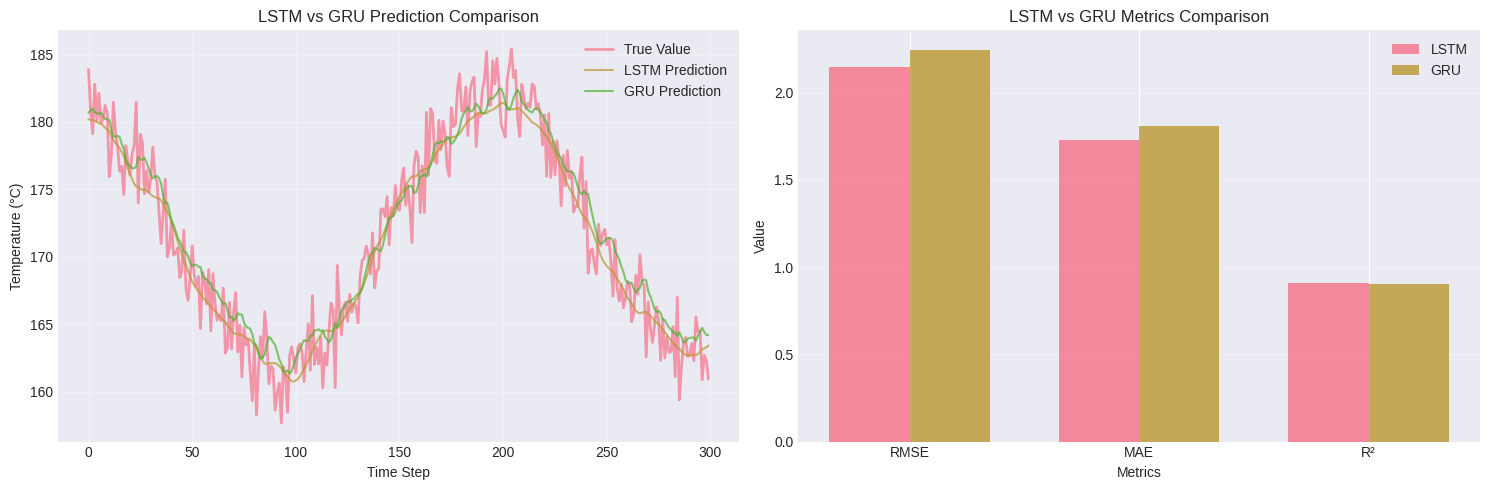

In [57]:
# 比較 LSTM 和 GRU
comparison_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'Parameters'],
    'LSTM': [
        results_lstm['MSE'],
        results_lstm['RMSE'],
        results_lstm['MAE'],
        results_lstm['R2'],
        lstm_model.count_params()
    ],
    'GRU': [
        results_gru['MSE'],
        results_gru['RMSE'],
        results_gru['MAE'],
        results_gru['R2'],
        gru_model.count_params()
    ]
})

print("\nLSTM vs GRU 效能比較:")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# 視覺化比較
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 預測比較
plot_range = range(0, 300)
axes[0].plot(y_test_inverse[plot_range], label='True Value', linewidth=2, alpha=0.7)
axes[0].plot(y_pred_lstm[plot_range], label='LSTM Prediction', linewidth=1.5, alpha=0.7)
axes[0].plot(y_pred_gru[plot_range], label='GRU Prediction', linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('LSTM vs GRU Prediction Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 指標比較
metrics_names = ['RMSE', 'MAE', 'R²']
metrics_lstm = [results_lstm['RMSE'], results_lstm['MAE'], results_lstm['R2']]
metrics_gru = [results_gru['RMSE'], results_gru['MAE'], results_gru['R2']]

x = np.arange(len(metrics_names))
width = 0.35

axes[1].bar(x - width/2, metrics_lstm, width, label='LSTM', alpha=0.8)
axes[1].bar(x + width/2, metrics_gru, width, label='GRU', alpha=0.8)
axes[1].set_xlabel('Metrics')
axes[1].set_ylabel('Value')
axes[1].set_title('LSTM vs GRU Metrics Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 3.11 LSTM/GRU 小結

✅ **完成項目**:
- 使用 LSTM 和 GRU 模型進行時間序列預測
- 學習如何準備時間序列數據（滑動窗口）
- 了解 LSTM 和 GRU 的差異與應用
- 掌握時間序列預測的評估方法

📊 **關鍵發現**:
- LSTM 和 GRU 都能有效捕捉時間序列的模式
- GRU 參數量較少，訓練速度較快
- LSTM 在複雜長期依賴問題上可能表現更好
- 適當的窗口大小對預測效能很重要

---

# 總結與學習重點

## 📝 本單元學習重點回顧

### 1. DNN/MLP 模型
- **適用場景**: 表格型數據、迴歸和分類問題
- **關鍵技術**: 
  - 多層全連接網路
  - Batch Normalization
  - Dropout 正則化
  - EarlyStopping 防止過擬合
- **應用實例**: 化工製程參數預測

### 2. CNN 模型
- **適用場景**: 圖像數據、具有空間或局部結構的數據
- **關鍵技術**:
  - 卷積層提取局部特徵
  - 池化層降低維度
  - 參數共享減少模型複雜度
  - GlobalAveragePooling
- **應用實例**: 光譜數據分類

### 3. LSTM/GRU 模型
- **適用場景**: 時間序列數據、序列預測問題
- **關鍵技術**:
  - 門控機制處理長期依賴
  - 滑動窗口準備序列數據
  - 多層 RNN 堆疊
  - LSTM vs GRU 選擇
- **應用實例**: 製程溫度時間序列預測

## 🎯 模型選擇指南

| 數據類型 | 推薦模型 | 理由 |
|----------|----------|------|
| 表格數據 (特徵向量) | DNN/MLP | 簡單高效，適合靜態特徵 |
| 圖像/光譜數據 | CNN | 自動提取空間/局部特徵 |
| 時間序列數據 | LSTM/GRU | 捕捉時間依賴關係 |
| 混合數據 | 組合模型 | 結合各模型優勢 |

## 💡 實作建議

1. **從簡單開始**: 先嘗試較淺的網路，逐步增加複雜度
2. **數據預處理**: 標準化/正規化對深度學習很重要
3. **正則化技巧**: 使用 Dropout、Batch Normalization 防止過擬合
4. **Early Stopping**: 監控驗證集表現，及時停止訓練
5. **超參數調整**: 系統性地調整學習率、批次大小、網路結構
6. **視覺化分析**: 繪製訓練曲線和預測結果，理解模型行為

## 🔍 常見問題處理

### 過擬合 (Overfitting)
- ✅ 增加 Dropout
- ✅ 使用正則化 (L1/L2)
- ✅ 減少模型複雜度
- ✅ 增加訓練數據

### 欠擬合 (Underfitting)
- ✅ 增加模型複雜度
- ✅ 訓練更多 epochs
- ✅ 調整學習率
- ✅ 減少正則化

### 訓練不穩定
- ✅ 降低學習率
- ✅ 使用 Batch Normalization
- ✅ 檢查數據標準化
- ✅ 使用梯度裁剪

## 📚 延伸學習

1. **進階模型架構**:
   - ResNet (殘差網路)
   - Attention 機制
   - Transformer

2. **遷移學習**:
   - 使用預訓練模型
   - Fine-tuning

3. **模型優化**:
   - 超參數調整 (Hyperparameter Tuning)
   - 模型壓縮與加速

4. **化工特定應用**:
   - 製程異常檢測
   - 反應器動態建模
   - 產品品質預測
   - 設備剩餘壽命預測

---

## ✅ 學習檢核清單

完成本單元後，您應該能夠：

- [ ] 理解 DNN、CNN、RNN 的基本原理和差異
- [ ] 根據問題類型選擇合適的深度學習模型
- [ ] 使用 TensorFlow/Keras 建立和訓練模型
- [ ] 設定和調整模型的關鍵參數
- [ ] 診斷和解決訓練過程中的常見問題
- [ ] 評估模型效能並解讀結果
- [ ] 將深度學習應用於化工領域問題

---

**恭喜完成 Unit 15 深度學習基礎模型！** 🎉

繼續學習下一單元，探索更進階的深度學習技術和應用！

---

*課程: 化工AI應用 - Part 4 深度學習*  
*單元: Unit 15 - 深度學習基礎模型*  
*更新日期: 2025-12-21*